In [46]:
import os
import time

import matplotlib.pyplot as plt
import timm_3d
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
from tqdm import tqdm
import logging
import seaborn as sn

from rsna_dataloader import *

In [47]:
import torch.nn as nn
import timm_3d
from spacecutter import *
from spacecutter.losses import *
from spacecutter.models import *
from spacecutter.callbacks import *


class CNN_Model_3D_Multihead(nn.Module):
    def __init__(self,
                 backbone="efficientnet_lite0",
                 in_chans=1,
                 out_classes=5,
                 cutpoint_margin=0.15,
                 pretrained=False):
        super(CNN_Model_3D_Multihead, self).__init__()
        self.out_classes = out_classes

        self.encoder = timm_3d.create_model(
            backbone,
            features_only=False,
            drop_rate=0,
            drop_path_rate=0,
            pretrained=pretrained,
            in_chans=in_chans,
            global_pool="max"
        )
        if "efficientnet" in backbone:
            head_in_dim = self.encoder.classifier.in_features
            self.encoder.classifier = nn.Sequential(
                nn.LayerNorm(head_in_dim),
                nn.Dropout(0),
            )

        elif "vit" in backbone:
            self.encoder.head.drop = nn.Dropout(0)
            head_in_dim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        self.heads = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(head_in_dim, 1),
                LogisticCumulativeLink(3)
            ) for i in range(out_classes)]
        )

        self.ascension_callback = AscensionCallback(margin=cutpoint_margin)

    def forward(self, x):
        feat = self.encoder(x)
        return torch.swapaxes(torch.stack([head(feat) for head in self.heads]), 0, 1)

    def _ascension_callback(self):
        for head in self.heads:
            self.ascension_callback.clip(head[-1])


In [3]:
import torch

model = CNN_Model_3D_Multihead(backbone="maxvit_rmlp_tiny_rw_256", in_chans=3, out_classes=25).to(device)
model.load_state_dict(torch.load("../models/maxvit_rmlp_tiny_rw_256_256_v2_fold_3/maxvit_rmlp_tiny_rw_256_256_v2_fold_3_32.pt"))
model.eval()

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3588.)


CNN_Model_3D_Multihead(
  (encoder): MaxxVit(
    (stem): Stem(
      (conv1): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (norm1): BatchNormAct3d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (conv2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (stages): Sequential(
      (0): MaxxVitStage(
        (blocks): Sequential(
          (0): MaxxVitBlock(
            (conv): MbConvBlock(
              (shortcut): Downsample3d(
                (pool): AvgPool3d(kernel_size=2, stride=2, padding=0)
                (expand): Identity()
              )
              (pre_norm): BatchNormAct3d(
                64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
                (drop): Identity()
                (act): Identity()
              )
              (down): Identity()
   

In [15]:
import numpy as np

DATA_BASEPATH = "../data/rsna-2024-lumbar-spine-degenerative-classification/"
TRAINING_DATA = retrieve_coordinate_training_data(DATA_BASEPATH)

conditions = sorted(TRAINING_DATA["condition"].unique())

transform = tio.Compose([
        tio.RescaleIntensity(out_min_max=(0, 1)),
    ])

(trainloader, valloader, test_loader,
 trainset, valset, testset) = create_study_level_datasets_and_loaders(TRAINING_DATA,
                                                                        transform_3d_train=transform,
                                                                        transform_3d_val=transform,
                                                                        base_path=os.path.join(
                                                                            DATA_BASEPATH,
                                                                            "train_images"),
                                                                        vol_size=(256, 256, 256),
                                                                        num_workers=0,
                                                                        split_factor=0.3,
                                                                        batch_size=1,
                                                                        use_mirroring_trick=True)

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [6]:
from torch.cuda.amp import autocast
from tqdm import tqdm

inferred = []
target = []

with torch.no_grad():
    with autocast(dtype=torch.bfloat16):
        for image, label in tqdm(test_loader):
            target.append(label.detach())
            inferred.append(model(image.to(device)).cpu().detach())
        for image, label in tqdm(valloader):
            target.append(label.detach())
            inferred.append(model(image.to(device)).cpu().detach())


100%|██████████| 401/401 [11:46<00:00,  1.76s/it]


In [7]:
inferred_new = []
target_new = []
for e in inferred:
    for elem in e:
        inferred_new.append(elem.reshape((-1, 25, 3)))
for e in target:
    for elem in e:
        target_new.append([[0 if i != elem_ else 1 for i in range(3)] for elem_ in elem])
        
        
inferred_new[1], target_new[1]

(tensor([[[9.6610e-01, 2.8546e-02, 5.3536e-03],
          [8.3525e-01, 1.4724e-01, 1.7512e-02],
          [3.3383e-01, 5.2808e-01, 1.3809e-01],
          [6.2485e-01, 3.2210e-01, 5.3045e-02],
          [7.1469e-01, 2.3377e-01, 5.1546e-02],
          [9.9465e-01, 4.6495e-03, 7.0071e-04],
          [1.9317e-01, 5.1445e-01, 2.9238e-01],
          [8.5597e-02, 4.2593e-01, 4.8848e-01],
          [3.2999e-01, 5.0203e-01, 1.6799e-01],
          [6.1447e-01, 3.1483e-01, 7.0696e-02],
          [9.8850e-01, 9.6942e-03, 1.8051e-03],
          [8.7941e-01, 1.0837e-01, 1.2220e-02],
          [4.3291e-01, 4.7029e-01, 9.6806e-02],
          [4.6091e-01, 4.3874e-01, 1.0036e-01],
          [6.0435e-01, 3.1027e-01, 8.5371e-02],
          [9.9566e-01, 3.7829e-03, 5.5665e-04],
          [4.1881e-01, 4.5888e-01, 1.2230e-01],
          [6.2710e-02, 3.6304e-01, 5.7425e-01],
          [2.2656e-01, 5.1908e-01, 2.5436e-01],
          [5.6597e-01, 3.4739e-01, 8.6639e-02],
          [9.9650e-01, 3.0274e-03, 4.720

In [8]:
inferred_l = [[np.argmax(e_) for e_ in e.detach().cpu()[0]] for e in inferred_new]
target_l = [[np.argmax(e_) for e_ in e] for e in target_new]

In [9]:
len(inferred_l[1]), len(target_l[1])

(25, 25)

In [61]:
conditions = ['Left Neural Foraminal Narrowing',
 'Left Subarticular Stenosis',
 'Right Neural Foraminal Narrowing',
 'Right Subarticular Stenosis',
 'Spinal Canal Stenosis']

levels = [
    "L1/L2",
    "L2/L3",
    "L3/L4",
    "L4/L5",
    "L5/S1",
]

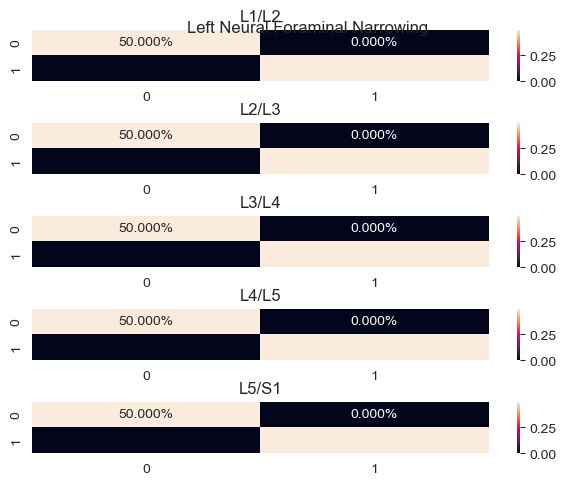

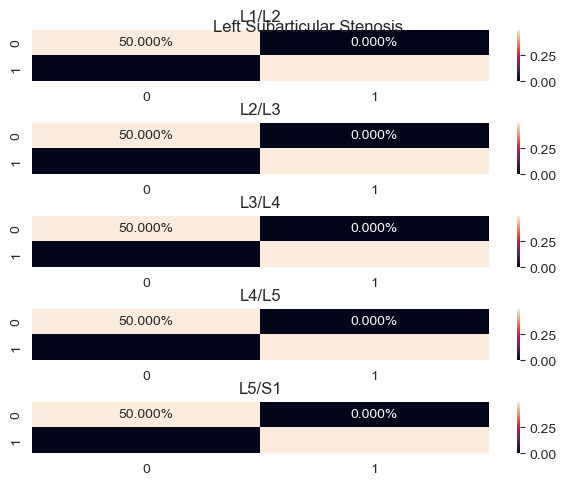

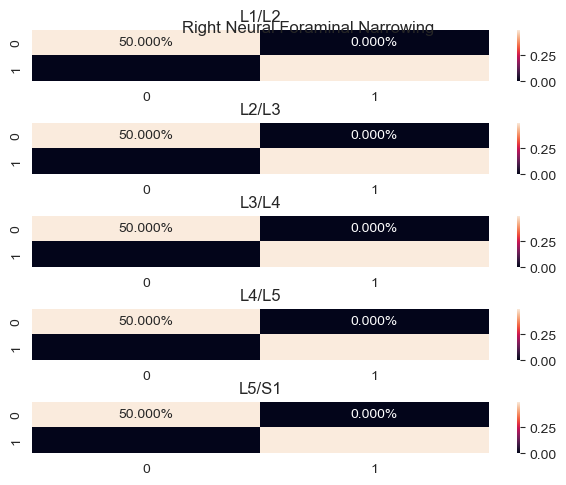

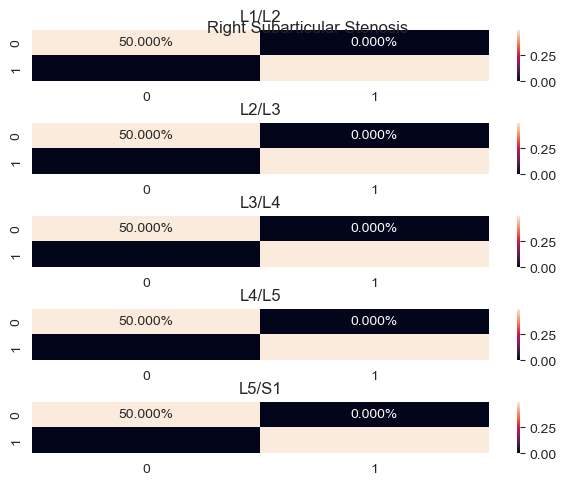

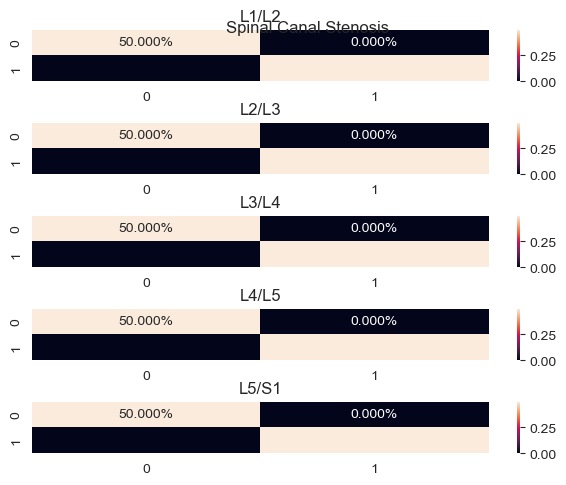

In [66]:
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from operator import truediv

precisions_l = []
recalls_l = []

precisions_r = []
recalls_r = []

precisions_c = []
recalls_c = []

for cond_ind, cond in enumerate(conditions):
    fig, ax = plt.subplots(nrows=5, squeeze=False)
    fig.tight_layout()

    for level_ind, level in enumerate(levels):
        i = cond_ind * 5 + level_ind
        
        target_ = [e[i] for e in target_l]
        inferred_ = [e[i] for e in inferred_l]
        
        ax[level_ind][0].set_title(level)
        
        cf_matrix = confusion_matrix(target_, inferred_)
        sn.heatmap(cf_matrix / (np.sum(cf_matrix) + 1e-7), ax=ax[level_ind][0], annot=True, fmt='.3%')
    
        true_pos = np.diag(cf_matrix)
        prec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=0) + 1e-7))
        rec = list(map(truediv, true_pos, np.sum(cf_matrix, axis=1) + 1e-7))
        
        if cond_ind == 4:
            precisions_c.append(prec)
            recalls_c.append(rec)
        elif cond_ind % 2 == 0:
            precisions_l.append(prec)
            recalls_l.append(rec)
        else:
            precisions_l.append(prec)
            recalls_l.append(rec)
        
    plt.suptitle(cond)
    plt.show()


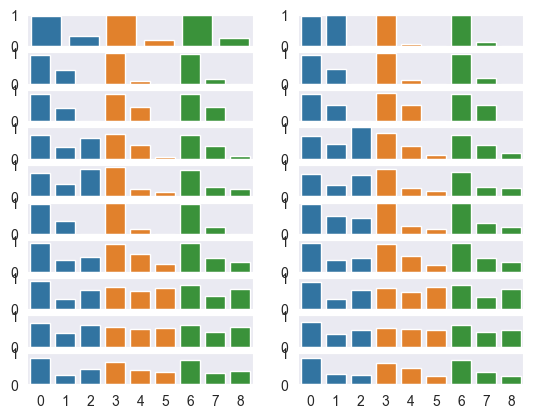

In [12]:
fig, ax = plt.subplots(nrows=10, ncols=2)
plt.set_loglevel('WARNING')
for i in range(10):
    try:
        ax[i][0].set(ylim=(0, 1))
        val_len = len(precisions_l[i])
        sn.barplot(x=range(val_len), y=precisions_l[i], ax=ax[i][0])
        sn.barplot(x=range(val_len, 2 * val_len), y=recalls_l[i], ax=ax[i][0])
        sn.barplot(x=range(2 * val_len, 3 * val_len), y=2 / (1 / (np.array(recalls_l[i]) + 1e-7) + 1 / (np.array(precisions_l[i]) + 1e-7)), ax=ax[i][0])
    except:
        pass
    
    try:
        ax[i][1].set(ylim=(0, 1))
        val_len = len(precisions_r[i])
        sn.barplot(x=range(val_len), y=precisions_r[i], ax=ax[i][1])
        sn.barplot(x=range(val_len, 2 * val_len), y=recalls_r[i], ax=ax[i][1])
        sn.barplot(x=range(2 * val_len, 3 * val_len), y=2 / (1 / (np.array(recalls_r[i]) + 1e-7) + 1 / (np.array(precisions_r[i]) + 1e-7)), ax=ax[i][1])
    except:
        pass
    
plt.show()

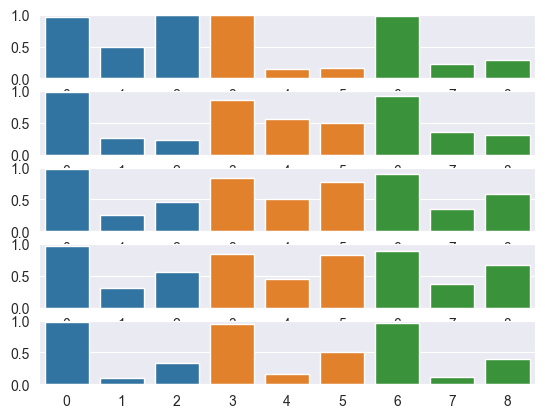

In [13]:
fig, ax = plt.subplots(nrows=5, ncols=1)
plt.set_loglevel('WARNING')
for i in range(5):
    try:
        val_len = len(precisions_c[i])
        ax[i].set(ylim=(0, 1))
        sn.barplot(x=range(val_len), y=precisions_c[i], ax=ax[i])
        sn.barplot(x=range(val_len, val_len * 2), y=recalls_c[i], ax=ax[i])
        sn.barplot(x=range(val_len * 2, val_len * 3), y=2 / (1 / (np.array(recalls_c[i]) + 1e-7) + 1 / (np.array(precisions_c[i]) + 1e-7)), ax=ax[i])
    except:
        pass

plt.show()

In [14]:
import timm_3d
timm_3d.list_models()

['coatnet_0_224',
 'coatnet_0_rw_224',
 'coatnet_1_224',
 'coatnet_1_rw_224',
 'coatnet_2_224',
 'coatnet_2_rw_224',
 'coatnet_3_224',
 'coatnet_3_rw_224',
 'coatnet_4_224',
 'coatnet_5_224',
 'coatnet_bn_0_rw_224',
 'coatnet_nano_cc_224',
 'coatnet_nano_rw_224',
 'coatnet_pico_rw_224',
 'coatnet_rmlp_0_rw_224',
 'coatnet_rmlp_1_rw2_224',
 'coatnet_rmlp_1_rw_224',
 'coatnet_rmlp_2_rw_224',
 'coatnet_rmlp_2_rw_384',
 'coatnet_rmlp_3_rw_224',
 'coatnet_rmlp_nano_rw_224',
 'coatnext_nano_rw_224',
 'convnext_atto',
 'convnext_atto_ols',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tin